In [1]:
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, locale, numpy as np, matplotlib.dates as mdates
from dateutil import parser
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter

In [2]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
sns.set()
sns.set_style('whitegrid')

df1 = pd.read_excel('RelatorioQualidadeAguasSuperficiais.xlsx')
df2 = pd.read_excel('RelatorioQualidadeAguasSuperficiais2.xlsx')

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.family'] = 'Open Sans'
#plt.rc('font', size=14) 
#plt.rc('axes', labelsize=20)
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize=15)
#plt.rc('legend', fontsize=15)

In [3]:
df1['Data Coleta']= pd.to_datetime(df1['Data Coleta'], infer_datetime_format = True)
df1_sorted = df1.sort_values('Data Coleta')

df2['Data Coleta']= pd.to_datetime(df2['Data Coleta'], infer_datetime_format = True)
df2_sorted = df2.sort_values('Data Coleta')

df1['Parametro'].unique()

array(['pH', 'Temperatura da Água', 'Temperatura do Ar',
       'Escherichia coli**', 'Alumínio Dissolvido', 'Cobre Dissolvido',
       'Cálcio Total', 'Magnésio Total',
       'Subst. Tensoat. reagem c/ Azul Metileno', 'Leitura da Régua (m)',
       'Cor Verdadeira', 'Condutividade', 'Turbidez',
       'Carbono Orgânico Dissolvido', 'Nitrogênio Kjeldahl',
       'Nitrogênio-Nitrito', 'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal',
       'Oxigênio Dissolvido', 'DBO (5, 20)', 'Fluoreto Total',
       'Sólido Dissolvido Total', 'Sólido Total', 'Dureza', 'Sódio',
       'Alumínio Total', 'Fósforo-Ortofosfato', 'Fósforo Total',
       'Sulfato Total', 'Cloreto Total', 'Potássio', 'Crômio Total',
       'Manganês Total', 'Ferro Total', 'Ferro Dissolvido',
       'Níquel Total', 'Cobre Total', 'Zinco Total',
       'Ens. Ecotoxic. C/ Ceriodaphnia dubia', 'Cádmio Total',
       'Bário Total', 'Mercúrio Total', 'Chumbo Total', 'Coloração',
       'Chuvas nas últimas 24h', 'Clorofila-a', 'Feofit

In [4]:
df_ecoli = df1_sorted.loc[df1_sorted['Parametro'] == 'Escherichia coli**']
df_fos = df1_sorted.loc[df1_sorted['Parametro'] == 'Fósforo Total']
df_ph = df1_sorted.loc[df1_sorted['Parametro'] == 'pH']
df_dbo = df1_sorted.loc[df1_sorted['Parametro'] == 'DBO (5, 20)']
df_t = df1_sorted.loc[df1_sorted['Parametro'] == 'Temperatura da Água']
df_turbidez = df1_sorted.loc[df1_sorted['Parametro'] == 'Turbidez']
df_residuo = df1_sorted.loc[df1_sorted['Parametro'] == 'Sólido Total']
df_o2d = df1_sorted.loc[df1_sorted['Parametro'] == 'Oxigênio Dissolvido']

In [5]:
valrs_IQA = {'q1': 0.0, 
             'q2': 0.0, 
             'q3': 0.0, 
             'q4': 0.0, 
             'q5': 0.0, 
             'q6': 0.0, 
             'q7': 0.0, 
             'q8': 0.0, 
             'q9': 0.0}

pesos_IQA = {'w1': 0.15, 
             'w2': 0.12, 
             'w3': 0.10, 
             'w4': 0.10, 
             'w5': 0.10, 
             'w6': 0.10, 
             'w7': 0.08, 
             'w8': 0.08, 
             'w9': 0.17}

In [6]:
def qi_calc(v, name):
    f_name = False
    
    if name == 'coliformes':
        f_name = True
        if v > 10**5:
            return 3
    elif name == 'ph':
        f_name = True
        if v < 2:
            return 2
        elif v > 12:
            return 3
    elif name == 'dbo':
        f_name = True
        if v > 30:
            return 2
    elif name == 'no2':
        f_name = True
        if v > 100:
            return 1
    elif name == 'fos':
        f_name = True
        if v > 10:
            return 1
    elif name == 't':
        f_name = True
        if v < -5:
            return None
        elif v > 15:
            return 9
    elif name == 'turbidez':
        f_name = True
        if v > 100:
            return 5
    elif name == 'residuo':
        f_name = True
        if v > 500:
            return 32
    elif name == 'o2d':
        f_name = True
        if v > 140:
            return 47
    
    if not f_name:
        raise ValueError('Nome de parâmetro não existe.')
    
    df = pd.read_excel(f'retrocesso/{name}.xlsx')
    v = float(v)
    df = df.round(1)
    dic = df.to_dict()
    
    va = 100000.0
    ia = None
    for i, value in dic['X'].items():
        vn = abs(v-value)
        if vn < va:
            ia = i
            va = vn
    return dic['Y'][ia]

In [7]:
df_coliformes = pd.DataFrame()
datas = set(df_ecoli['Data Coleta'].tolist())

for d in datas:
    ecoli = (df1_sorted.loc[(df1_sorted['Data Coleta'] == d) & (df1_sorted['Parametro'] == 'Escherichia coli**')])['Valor'].tolist()[0]
    
    ecoli = round(float(ecoli.replace(',', '.')), 2)
    value = round((ecoli/1.25), 2)
    
    row = (df1_sorted.loc[(df1_sorted['Data Coleta'] == d) & (df1_sorted['Parametro'] == 'Escherichia coli**')]).to_dict(orient='records')
    row = row[0]
    row['Parametro'] = 'Coliformes Fecais'
    row['Valor'] = value
    df_coliformes = df_coliformes.append(row, ignore_index = True)
    
df_coliformes = df_coliformes.sort_values('Data Coleta')

In [8]:
df_no2 = df1_sorted.loc[(df1_sorted['Parametro'] == 'Nitrogênio-Nitrito') | (df1_sorted['Parametro'] == 'Nitrogênio-Nitrato') | (df1_sorted['Parametro'] == 'Nitrogênio Kjeldahl')]
df_no2_t = pd.DataFrame()
datas = set(df_no2['Data Coleta'].tolist())

for d in datas:
    nitrito = (df_no2.loc[(df_no2['Data Coleta'] == d) & (df_no2['Parametro'] == 'Nitrogênio-Nitrito')])['Valor'].tolist()[0]
    nitrato = (df_no2.loc[(df_no2['Data Coleta'] == d) & (df_no2['Parametro'] == 'Nitrogênio-Nitrato')])['Valor'].tolist()[0]
    kjeldahl = (df_no2.loc[(df_no2['Data Coleta'] == d) & (df_no2['Parametro'] == 'Nitrogênio Kjeldahl')])['Valor'].tolist()[0]
    
    nitrito = round(float(nitrito.replace(',', '.')), 2)
    nitrato = round(float(nitrato.replace(',', '.')), 2)
    kjeldahl = round(float(kjeldahl.replace(',', '.')), 2)
    value = round((nitrito + nitrato + kjeldahl), 2)
    
    row = (df_no2.loc[(df_no2['Data Coleta'] == d) & (df_no2['Parametro'] == 'Nitrogênio-Nitrito')]).to_dict(orient='records')
    row = row[0]
    row['Parametro'] = 'Nitrogênio Total'
    row['Valor'] = value
    df_no2_t = df_no2_t.append(row, ignore_index = True)
    
df_no2_t = df_no2_t.sort_values('Data Coleta')

In [9]:
df_deltat = pd.DataFrame()
datas = set(df_t['Data Coleta'].tolist())

for d in datas:
    t_agua = (df1_sorted.loc[(df1_sorted['Data Coleta'] == d) & (df1_sorted['Parametro'] == 'Temperatura da Água')])['Valor'].tolist()[0]
    t_amb = (df1_sorted.loc[(df1_sorted['Data Coleta'] == d) & (df1_sorted['Parametro'] == 'Temperatura do Ar')])['Valor'].tolist()[0]

    t_agua = round(float(t_agua.replace(',', '.')), 2)
    t_amb = round(float(t_amb.replace(',', '.')), 2)
    value = round(((t_amb - t_agua)), 2)
    
    row = (df1_sorted.loc[(df1_sorted['Data Coleta'] == d) & (df1_sorted['Parametro'] == 'Temperatura do Ar')]).to_dict(orient='records')
    row = row[0]
    row['Parametro'] = 'Delta T'
    row['Valor'] = value
    df_deltat = df_deltat.append(row, ignore_index = True)
    
df_deltat = df_deltat.sort_values('Data Coleta')

In [10]:
# df_o2_n = pd.DataFrame()
# datas = set(df_o2d['Data Coleta'].tolist())

# for d in datas:
#     value = (df_o2d.loc[(df_o2d['Data Coleta'] == d) & (df_o2d['Parametro'] == 'Oxigênio Dissolvido')])['Valor'].tolist()[0]
    
#     value = round(float(value.replace(',', '.')), 2)
#     sat = round(((value/8)*1000), 2)
    
#     row = (df_o2d.loc[(df_o2d['Data Coleta'] == d) & (df_o2d['Parametro'] == 'Oxigênio Dissolvido')]).to_dict(orient='records')
#     row = row[0]
#     row['Parametro'] = '% Saturação O2'
#     row['Valor'] = value
#     df_o2_n = df_o2_n.append(row, ignore_index = True)
    
# df_o2_n = df_o2_n.sort_values('Data Coleta')

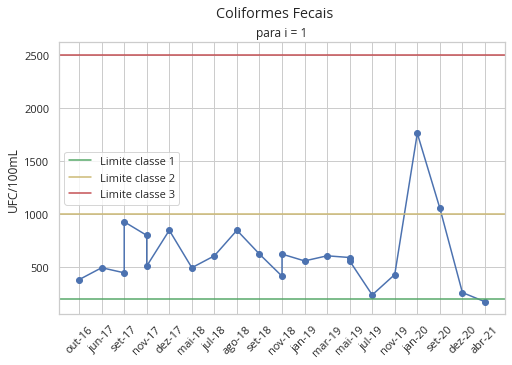

In [11]:
unidade = df_coliformes['Unidade'].values[0]
df_coliformes['Data Coleta'] = df_coliformes['Data Coleta'].dt.strftime('%b-%y')
x = df_coliformes['Data Coleta'].tolist()
y = df_coliformes['Valor'].tolist()

#safe1 = [200]*len(y)
#safe2 = [1000]*len(y)
#safe3 = [2500]*len(y)
safe1 = 200
safe2 = 1000
safe3 = 2500

plt.plot(x, y)
plt.scatter(x, y)
plt.ylabel(unidade)
plt.suptitle('Coliformes Fecais')
plt.title('para i = 1')
plt.xticks(rotation=45)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
#plt.plot(x, safe3, c='r', label='Limite classe 3')
plt.axhline(y=safe1, color='g', linestyle='-', label='Limite classe 1')
plt.axhline(y=safe2, color='y', linestyle='-', label='Limite classe 2')
plt.axhline(y=safe3, color='r', linestyle='-', label='Limite classe 3')
#plt.ylim([0, 5000])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend()
plt.savefig('coliformes.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/531787742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ph['Data Coleta'] = df_ph['Data Coleta'].dt.strftime('%b-%y')


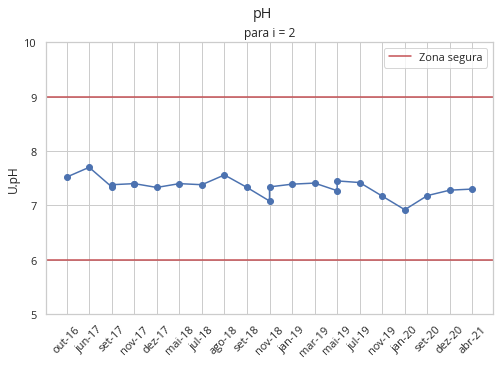

In [12]:
unidade = df_ph['Unidade'].values[0]
df_ph['Data Coleta'] = df_ph['Data Coleta'].dt.strftime('%b-%y')
x = df_ph['Data Coleta'].tolist()
y = df_ph['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [6]*len(y)
#safe2 = [9]*len(y)
safe1 = 6
safe2 = 9

plt.plot(x, y)
plt.scatter(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='r', label='Zona segura')
plt.axhline(y=safe1, color='r', linestyle='-', label='Zona segura')
plt.axhline(y=safe2, color='r', linestyle='-')
#plt.annotate('Zona segura', ((mdates.date2num(x[-15]), safe2[0]+0.25)))
#plt.plot(x, safe2, c='r')
#plt.annotate('Zona segura', ((mdates.date2num(x[-15]), safe1[0]-0.4)))
plt.suptitle('pH')
plt.title('para i = 2')
plt.xticks(rotation=45)
plt.ylim([5, 10])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend()
plt.savefig('ph.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/3872687493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dbo['Data Coleta'] = df_dbo['Data Coleta'].dt.strftime('%b-%y')


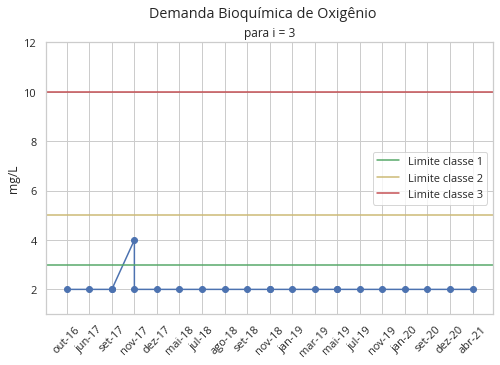

In [13]:
unidade = df_dbo['Unidade'].values[0]
df_dbo['Data Coleta'] = df_dbo['Data Coleta'].dt.strftime('%b-%y')
x = df_dbo['Data Coleta'].tolist()
y = df_dbo['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [3]*len(y)
#safe2 = [5]*len(y)
#safe3 = [10]*len(y)
safe1 = 3
safe2 = 5
safe3 = 10

plt.plot(x, y)
plt.scatter(x, y)
plt.ylabel(unidade)
plt.suptitle('Demanda Bioquímica de Oxigênio')
plt.title('para i = 3')
plt.xticks(rotation=45)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
#plt.plot(x, safe3, c='r', label='Limite classe 3')
plt.axhline(y=safe1, color='g', linestyle='-', label='Limite classe 1')
plt.axhline(y=safe2, color='y', linestyle='-', label='Limite classe 2')
plt.axhline(y=safe3, color='r', linestyle='-', label='Limite classe 3')
plt.ylim([1, 12])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend()
plt.savefig('dbo.png')
plt.show()

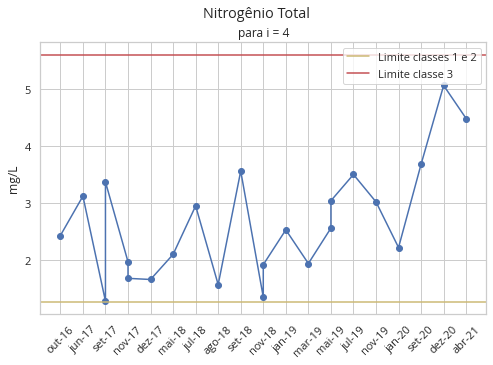

In [14]:
unidade = df_no2_t['Unidade'].values[0]
df_no2_t['Data Coleta'] = df_no2_t['Data Coleta'].dt.strftime('%b-%y')
x = df_no2_t['Data Coleta'].tolist()
y = df_no2_t['Valor'].tolist()

# df_nitrito = df1_sorted.loc[df1_sorted['Parametro'] == 'Nitrogênio-Nitrito']
# x2 = df_nitrito['Data Coleta'].tolist()
# y2 = df_nitrito['Valor'].tolist()
# y2 = [round(float(i.replace(',', '.')), 2) for i in y2]
# df_nitrato = df1_sorted.loc[df1_sorted['Parametro'] == 'Nitrogênio-Nitrato']
# x3 = df_nitrato['Data Coleta'].tolist()
# y3 = df_nitrato['Valor'].tolist()
# y3 = [round(float(i.replace(',', '.')), 2) for i in y3]
# df_kjeldahl = df1_sorted.loc[df1_sorted['Parametro'] == 'Nitrogênio Kjeldahl']
# x4 = df_kjeldahl['Data Coleta'].tolist()
# y4 = df_kjeldahl['Valor'].tolist()
# y4 = [round(float(i.replace(',', '.')), 2) for i in y4]

#safe1 = [1.27]*len(y)
#safe2 = [2.18]*len(y)
safe1 = 1.27
safe2 = 5.6

# plt.plot(x2, y2, c='k')
# plt.plot(x3, y3, c='k')
# plt.plot(x4, y4, c='k')
# plt.scatter(x2, y2, c='k')
# plt.scatter(x3, y3, c='k')
# plt.scatter(x4, y4, c='k')
plt.plot(x, y)
plt.scatter(x, y)
plt.ylabel(unidade)
plt.suptitle('Nitrogênio Total')
plt.title('para i = 4')
plt.xticks(rotation=45)
plt.axhline(y=safe1, color='y', linestyle='-', label='Limite classes 1 e 2')
plt.axhline(y=safe2, color='r', linestyle='-', label='Limite classe 3')
#plt.plot(x, safe1, c='g', label='Limite classe 2')
#plt.plot(x, safe2, c='r', label='Limite classe 3')
#plt.ylim([1, 12])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend()
plt.savefig('no2.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/3835171610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fos['Data Coleta'] = df_fos['Data Coleta'].dt.strftime('%b-%y')


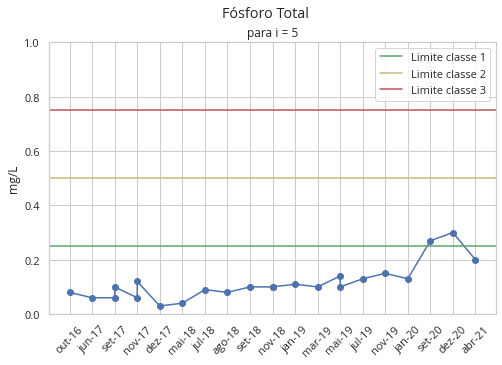

In [15]:
unidade = df_fos['Unidade'].values[0]
df_fos['Data Coleta'] = df_fos['Data Coleta'].dt.strftime('%b-%y')
x = df_fos['Data Coleta'].tolist()
y = df_fos['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [0.25]*len(y)
#safe2 = [0.5]*len(y)
#safe3 = [0.75]*len(y)
safe1 = 0.25
safe2 = 0.5
safe3 = 0.75

plt.scatter(x, y)
plt.plot(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
#plt.plot(x, safe3, c='r', label='Limite classe 3')
plt.axhline(y=safe1, color='g', linestyle='-', label='Limite classe 1')
plt.axhline(y=safe2, color='y', linestyle='-', label='Limite classe 2')
plt.axhline(y=safe3, color='r', linestyle='-', label='Limite classe 3')
plt.suptitle('Fósforo Total')
plt.title('para i = 5')
plt.xticks(rotation=45)
plt.ylim([0, 1])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='x', tight=False)
plt.legend()
plt.savefig('fos.png')
plt.show()

No handles with labels found to put in legend.


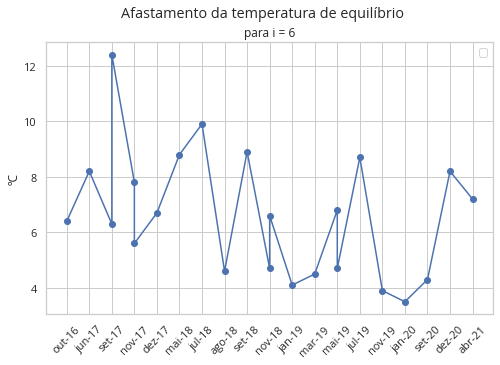

In [16]:
unidade = df_deltat['Unidade'].values[0]
df_deltat['Data Coleta'] = df_deltat['Data Coleta'].dt.strftime('%b-%y')
x = df_deltat['Data Coleta'].tolist()
y = df_deltat['Valor'].tolist()
#y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [0.25]*len(y)
#safe2 = [0.5]*len(y)
#safe3 = [0.75]*len(y)

plt.scatter(x, y)
plt.plot(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
#plt.plot(x, safe3, c='r', label='Limite classe 3')
plt.suptitle('Afastamento da temperatura de equilíbrio')
plt.title('para i = 6')
plt.xticks(rotation=45)
#plt.ylim([0, 1])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig('t.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/2673931891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_turbidez['Data Coleta'] = df_turbidez['Data Coleta'].dt.strftime('%b-%y')


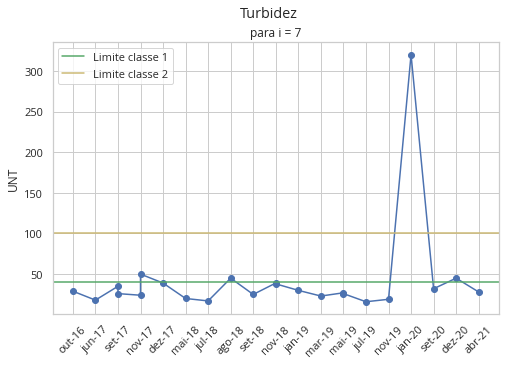

In [17]:
unidade = df_turbidez['Unidade'].values[0]
df_turbidez['Data Coleta'] = df_turbidez['Data Coleta'].dt.strftime('%b-%y')
x = df_turbidez['Data Coleta'].tolist()
y = df_turbidez['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [40]*len(y)
#afe2 = [100]*len(y)
safe1 = 40
safe2 = 100

plt.scatter(x, y)
plt.plot(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
plt.axhline(y=safe1, color='g', linestyle='-', label='Limite classe 1')
plt.axhline(y=safe2, color='y', linestyle='-', label='Limite classe 2')
plt.suptitle('Turbidez')
plt.title('para i = 7')
plt.xticks(rotation=45)
#plt.ylim([0, 1])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig('turbidez.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/1156128394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residuo['Data Coleta'] = df_residuo['Data Coleta'].dt.strftime('%b-%y')
No handles with labels found to put in legend.


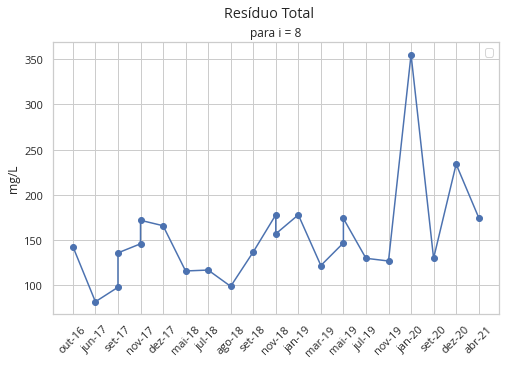

In [18]:
unidade = df_residuo['Unidade'].values[0]
df_residuo['Data Coleta'] = df_residuo['Data Coleta'].dt.strftime('%b-%y')
x = df_residuo['Data Coleta'].tolist()
y = df_residuo['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [40]*len(y)
#safe2 = [100]*len(y)

plt.scatter(x, y)
plt.plot(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='r', label='Limite classe 2')
plt.suptitle('Resíduo Total')
plt.title('para i = 8')
plt.xticks(rotation=45)
#plt.ylim([0, 1])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig('residuo.png')
plt.show()

D:\AppData\Local\Temp/ipykernel_18048/1559004599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_o2d['Data Coleta'] = df_o2d['Data Coleta'].dt.strftime('%b-%y')


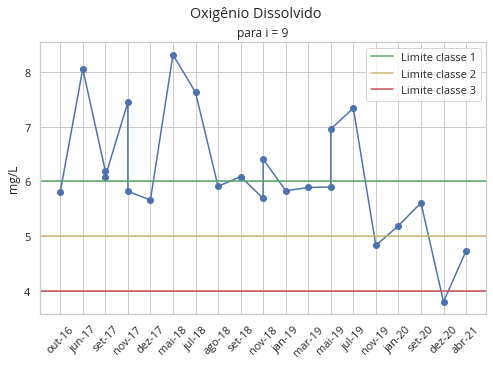

In [19]:
unidade = df_o2d['Unidade'].values[0]
df_o2d['Data Coleta'] = df_o2d['Data Coleta'].dt.strftime('%b-%y')
x = df_o2d['Data Coleta'].tolist()
y = df_o2d['Valor'].tolist()
y = [round(float(i.replace(',', '.')), 2) for i in y]

#safe1 = [6]*len(y)
#safe2 = [5]*len(y)
#safe3 = [4]*len(y)
safe1 = 6
safe2 = 5
safe3 = 4

plt.scatter(x, y)
plt.plot(x, y)
plt.ylabel(unidade)
#plt.plot(x, safe1, c='g', label='Limite classe 1')
#plt.plot(x, safe2, c='y', label='Limite classe 2')
#plt.plot(x, safe3, c='r', label='Limite classe 3')
plt.axhline(y=safe1, color='g', linestyle='-', label='Limite classe 1')
plt.axhline(y=safe2, color='y', linestyle='-', label='Limite classe 2')
plt.axhline(y=safe3, color='r', linestyle='-', label='Limite classe 3')
plt.suptitle('Oxigênio Dissolvido')
plt.title('para i = 9')
plt.xticks(rotation=45)
#plt.ylim([0, 1])
#plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig('o2d.png')
plt.show()

In [29]:
valrs_IQA_21 = valrs_IQA.copy()

q1_21 = (df_coliformes['Valor'].values[-1])
q2_21 = (df_ph['Valor'].values[-1])
q3_21 = (df_dbo['Valor'].values[-1])
q4_21 = (df_no2_t['Valor'].values[-1])
q5_21 = (df_fos['Valor'].values[-1])
q6_21 = (df_deltat['Valor'].values[-1])
q7_21 = (df_turbidez['Valor'].values[-1])
q8_21 = (df_residuo['Valor'].values[-1])
q9_21 = (df_o2d['Valor'].values[-1])

#q1_21 = round(float(q1_21.replace(',', '.')), 2)
q2_21 = round(float(q2_21.replace(',', '.')), 2)
q3_21 = round(float(q3_21.replace(',', '.')), 2)
#q4_21 = round(float(q4_21.replace(',', '.')), 2)
q5_21 = round(float(q5_21.replace(',', '.')), 2)
#q6_21 = round(float(q6_21.replace(',', '.')), 2)
q7_21 = round(float(q7_21.replace(',', '.')), 2)
q8_21 = round(float(q8_21.replace(',', '.')), 2)
q9_21 = ((round(float(q9_21.replace(',', '.')), 2))/8)*100

valrs_IQA_21['q1'] = qi_calc(q1_21, 'coliformes')
valrs_IQA_21['q2'] = qi_calc(q2_21, 'ph')
valrs_IQA_21['q3'] = qi_calc(q3_21, 'dbo')
valrs_IQA_21['q4'] = qi_calc(q4_21, 'no2')
valrs_IQA_21['q5'] = qi_calc(q5_21, 'fos')
valrs_IQA_21['q6'] = qi_calc(q6_21, 't')
valrs_IQA_21['q7'] = qi_calc(q7_21, 'turbidez')
valrs_IQA_21['q8'] = qi_calc(q8_21, 'residuo')
valrs_IQA_21['q9'] = qi_calc(q9_21, 'o2d')

print(valrs_IQA_21)

valrs_IQA_21['q1'] **= pesos_IQA['w1']
valrs_IQA_21['q2'] **= pesos_IQA['w2']
valrs_IQA_21['q3'] **= pesos_IQA['w3']
valrs_IQA_21['q4'] **= pesos_IQA['w4']
valrs_IQA_21['q5'] **= pesos_IQA['w5']
valrs_IQA_21['q6'] **= pesos_IQA['w6']
valrs_IQA_21['q7'] **= pesos_IQA['w7']
valrs_IQA_21['q8'] **= pesos_IQA['w8']
valrs_IQA_21['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_21 = 1
for q in valrs_IQA_21.values():
    iqa_21 *= q
iqa_21 = round(iqa_21, 1)

iqa_21

{'q1': 34.1, 'q2': 91.0, 'q3': 84.2, 'q4': 70.5, 'q5': 92.5, 'q6': 31.1, 'q7': 54.9, 'q8': 77.5, 'q9': 57.5}


59.9

In [21]:
valrs_IQA_20 = valrs_IQA.copy()

q1_20 = (df_coliformes['Valor'].values[-2])
q2_20 = (df_ph['Valor'].values[-2])
q3_20 = (df_dbo['Valor'].values[-2])
q4_20 = (df_no2_t['Valor'].values[-2])
q5_20 = (df_fos['Valor'].values[-2])
q6_20 = (df_deltat['Valor'].values[-2])
q7_20 = (df_turbidez['Valor'].values[-2])
q8_20 = (df_residuo['Valor'].values[-2])
q9_20 = (df_o2d['Valor'].values[-2])

#q1_20 = round(float(q1_20.replace(',', '.')), 2)
q2_20 = round(float(q2_20.replace(',', '.')), 2)
q3_20 = round(float(q3_20.replace(',', '.')), 2)
#q4_20 = round(float(q4_20.replace(',', '.')), 2)
q5_20 = round(float(q5_20.replace(',', '.')), 2)
#q6_20 = round(float(q6_20.replace(',', '.')), 2)
q7_20 = round(float(q7_20.replace(',', '.')), 2)
q8_20 = round(float(q8_20.replace(',', '.')), 2)
q9_20 = ((round(float(q9_20.replace(',', '.')), 2))/8)*100

valrs_IQA_20['q1'] = qi_calc(q1_20, 'coliformes')
valrs_IQA_20['q2'] = qi_calc(q2_20, 'ph')
valrs_IQA_20['q3'] = qi_calc(q3_20, 'dbo')
valrs_IQA_20['q4'] = qi_calc(q4_20, 'no2')
valrs_IQA_20['q5'] = qi_calc(q5_20, 'fos')
valrs_IQA_20['q6'] = qi_calc(q6_20, 't')
valrs_IQA_20['q7'] = qi_calc(q7_20, 'turbidez')
valrs_IQA_20['q8'] = qi_calc(q8_20, 'residuo')
valrs_IQA_20['q9'] = qi_calc(q9_20, 'o2d')

valrs_IQA_20['q1'] **= pesos_IQA['w1']
valrs_IQA_20['q2'] **= pesos_IQA['w2']
valrs_IQA_20['q3'] **= pesos_IQA['w3']
valrs_IQA_20['q4'] **= pesos_IQA['w4']
valrs_IQA_20['q5'] **= pesos_IQA['w5']
valrs_IQA_20['q6'] **= pesos_IQA['w6']
valrs_IQA_20['q7'] **= pesos_IQA['w7']
valrs_IQA_20['q8'] **= pesos_IQA['w8']
valrs_IQA_20['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_20 = 1
for q in valrs_IQA_20.values():
    iqa_20 *= q
iqa_20 = round(iqa_20, 1)

iqa_20

51.8

In [22]:
valrs_IQA_19 = valrs_IQA.copy()

q1_19 = (df_coliformes['Valor'].values[-5])
q2_19 = (df_ph['Valor'].values[-5])
q3_19 = (df_dbo['Valor'].values[-5])
q4_19 = (df_no2_t['Valor'].values[-5])
q5_19 = (df_fos['Valor'].values[-5])
q6_19 = (df_deltat['Valor'].values[-5])
q7_19 = (df_turbidez['Valor'].values[-5])
q8_19 = (df_residuo['Valor'].values[-5])
q9_19 = (df_o2d['Valor'].values[-5])

#q1_19 = round(float(q1_19.replace(',', '.')), 2)
q2_19 = round(float(q2_19.replace(',', '.')), 2)
q3_19 = round(float(q3_19.replace(',', '.')), 2)
#q4_19 = round(float(q4_19.replace(',', '.')), 2)
q5_19 = round(float(q5_19.replace(',', '.')), 2)
#q6_19 = round(float(q6_19.replace(',', '.')), 2)
q7_19 = round(float(q7_19.replace(',', '.')), 2)
q8_19 = round(float(q8_19.replace(',', '.')), 2)
q9_19 = ((round(float(q9_19.replace(',', '.')), 2))/8)*100

valrs_IQA_19['q1'] = qi_calc(q1_19, 'coliformes')
valrs_IQA_19['q2'] = qi_calc(q2_19, 'ph')
valrs_IQA_19['q3'] = qi_calc(q3_19, 'dbo')
valrs_IQA_19['q4'] = qi_calc(q4_19, 'no2')
valrs_IQA_19['q5'] = qi_calc(q5_19, 'fos')
valrs_IQA_19['q6'] = qi_calc(q6_19, 't')
valrs_IQA_19['q7'] = qi_calc(q7_19, 'turbidez')
valrs_IQA_19['q8'] = qi_calc(q8_19, 'residuo')
valrs_IQA_19['q9'] = qi_calc(q9_19, 'o2d')

valrs_IQA_19['q1'] **= pesos_IQA['w1']
valrs_IQA_19['q2'] **= pesos_IQA['w2']
valrs_IQA_19['q3'] **= pesos_IQA['w3']
valrs_IQA_19['q4'] **= pesos_IQA['w4']
valrs_IQA_19['q5'] **= pesos_IQA['w5']
valrs_IQA_19['q6'] **= pesos_IQA['w6']
valrs_IQA_19['q7'] **= pesos_IQA['w7']
valrs_IQA_19['q8'] **= pesos_IQA['w8']
valrs_IQA_19['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_19 = 1
for q in valrs_IQA_19.values():
    iqa_19 *= q
iqa_19 = round(iqa_19, 1)

iqa_19

63.3

In [23]:
valrs_IQA_18 = valrs_IQA.copy()

q1_18 = (df_coliformes['Valor'].values[-10])
q2_18 = (df_ph['Valor'].values[-10])
q3_18 = (df_dbo['Valor'].values[-10])
q4_18 = (df_no2_t['Valor'].values[-10])
q5_18 = (df_fos['Valor'].values[-10])
q6_18 = (df_deltat['Valor'].values[-10])
q7_18 = (df_turbidez['Valor'].values[-10])
q8_18 = (df_residuo['Valor'].values[-10])
q9_18 = (df_o2d['Valor'].values[-10])

#q1_18 = round(float(q1_18.replace(',', '.')), 2)
q2_18 = round(float(q2_18.replace(',', '.')), 2)
q3_18 = round(float(q3_18.replace(',', '.')), 2)
#q4_18 = round(float(q4_18.replace(',', '.')), 2)
q5_18 = round(float(q5_18.replace(',', '.')), 2)
#q6_18 = round(float(q6_18.replace(',', '.')), 2)
q7_18 = round(float(q7_18.replace(',', '.')), 2)
q8_18 = round(float(q8_18.replace(',', '.')), 2)
q9_18 = ((round(float(q9_18.replace(',', '.')), 2))/8)*100

valrs_IQA_18['q1'] = qi_calc(q1_18, 'coliformes')
valrs_IQA_18['q2'] = qi_calc(q2_18, 'ph')
valrs_IQA_18['q3'] = qi_calc(q3_18, 'dbo')
valrs_IQA_18['q4'] = qi_calc(q4_18, 'no2')
valrs_IQA_18['q5'] = qi_calc(q5_18, 'fos')
valrs_IQA_18['q6'] = qi_calc(q6_18, 't')
valrs_IQA_18['q7'] = qi_calc(q7_18, 'turbidez')
valrs_IQA_18['q8'] = qi_calc(q8_18, 'residuo')
valrs_IQA_18['q9'] = qi_calc(q9_18, 'o2d')

valrs_IQA_18['q1'] **= pesos_IQA['w1']
valrs_IQA_18['q2'] **= pesos_IQA['w2']
valrs_IQA_18['q3'] **= pesos_IQA['w3']
valrs_IQA_18['q4'] **= pesos_IQA['w4']
valrs_IQA_18['q5'] **= pesos_IQA['w5']
valrs_IQA_18['q6'] **= pesos_IQA['w6']
valrs_IQA_18['q7'] **= pesos_IQA['w7']
valrs_IQA_18['q8'] **= pesos_IQA['w8']
valrs_IQA_18['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_18 = 1
for q in valrs_IQA_18.values():
    iqa_18 *= q
iqa_18 = round(iqa_18, 1)

iqa_18

64.3

In [24]:
valrs_IQA_17 = valrs_IQA.copy()

q1_17 = (df_coliformes['Valor'].values[4])
q2_17 = (df_ph['Valor'].values[4])
q3_17 = (df_dbo['Valor'].values[4])
q4_17 = (df_no2_t['Valor'].values[4])
q5_17 = (df_fos['Valor'].values[4])
q6_17 = (df_deltat['Valor'].values[4])
q7_17 = (df_turbidez['Valor'].values[4])
q8_17 = (df_residuo['Valor'].values[4])
q9_17 = (df_o2d['Valor'].values[4])

#q1_17 = round(float(q1_17.replace(',', '.')), 2)
q2_17 = round(float(q2_17.replace(',', '.')), 2)
q3_17 = round(float(q3_17.replace(',', '.')), 2)
#q4_17 = round(float(q4_17.replace(',', '.')), 2)
q5_17 = round(float(q5_17.replace(',', '.')), 2)
#q6_17 = round(float(q6_17.replace(',', '.')), 2)
q7_17 = round(float(q7_17.replace(',', '.')), 2)
q8_17 = round(float(q8_17.replace(',', '.')), 2)
q9_17 = ((round(float(q9_17.replace(',', '.')), 2))/8)*100

valrs_IQA_17['q1'] = qi_calc(q1_17, 'coliformes')
valrs_IQA_17['q2'] = qi_calc(q2_17, 'ph')
valrs_IQA_17['q3'] = qi_calc(q3_17, 'dbo')
valrs_IQA_17['q4'] = qi_calc(q4_17, 'no2')
valrs_IQA_17['q5'] = qi_calc(q5_17, 'fos')
valrs_IQA_17['q6'] = qi_calc(q6_17, 't')
valrs_IQA_17['q7'] = qi_calc(q7_17, 'turbidez')
valrs_IQA_17['q8'] = qi_calc(q8_17, 'residuo')
valrs_IQA_17['q9'] = qi_calc(q9_17, 'o2d')

valrs_IQA_17['q1'] **= pesos_IQA['w1']
valrs_IQA_17['q2'] **= pesos_IQA['w2']
valrs_IQA_17['q3'] **= pesos_IQA['w3']
valrs_IQA_17['q4'] **= pesos_IQA['w4']
valrs_IQA_17['q5'] **= pesos_IQA['w5']
valrs_IQA_17['q6'] **= pesos_IQA['w6']
valrs_IQA_17['q7'] **= pesos_IQA['w7']
valrs_IQA_17['q8'] **= pesos_IQA['w8']
valrs_IQA_17['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_17 = 1
for q in valrs_IQA_17.values():
    iqa_17 *= q
iqa_17 = round(iqa_17, 1)

iqa_17

60.9

In [25]:
valrs_IQA_16 = valrs_IQA.copy()

q1_16 = (df_coliformes['Valor'].values[0])
q2_16 = (df_ph['Valor'].values[0])
q3_16 = (df_dbo['Valor'].values[0])
q4_16 = (df_no2_t['Valor'].values[0])
q5_16 = (df_fos['Valor'].values[0])
q6_16 = (df_deltat['Valor'].values[0])
q7_16 = (df_turbidez['Valor'].values[0])
q8_16 = (df_residuo['Valor'].values[0])
q9_16 = (df_o2d['Valor'].values[0])

#q1_16 = round(float(q1_16.replace(',', '.')), 2)
q2_16 = round(float(q2_16.replace(',', '.')), 2)
q3_16 = round(float(q3_16.replace(',', '.')), 2)
#q4_16 = round(float(q4_16.replace(',', '.')), 2)
q5_16 = round(float(q5_16.replace(',', '.')), 2)
#q6_16 = round(float(q6_16.replace(',', '.')), 2)
q7_16 = round(float(q7_16.replace(',', '.')), 2)
q8_16 = round(float(q8_16.replace(',', '.')), 2)
q9_16 = ((round(float(q9_16.replace(',', '.')), 2))/8)*100

valrs_IQA_16['q1'] = qi_calc(q1_16, 'coliformes')
valrs_IQA_16['q2'] = qi_calc(q2_16, 'ph')
valrs_IQA_16['q3'] = qi_calc(q3_16, 'dbo')
valrs_IQA_16['q4'] = qi_calc(q4_16, 'no2')
valrs_IQA_16['q5'] = qi_calc(q5_16, 'fos')
valrs_IQA_16['q6'] = qi_calc(q6_16, 't')
valrs_IQA_16['q7'] = qi_calc(q7_16, 'turbidez')
valrs_IQA_16['q8'] = qi_calc(q8_16, 'residuo')
valrs_IQA_16['q9'] = qi_calc(q9_16, 'o2d')

valrs_IQA_16['q1'] **= pesos_IQA['w1']
valrs_IQA_16['q2'] **= pesos_IQA['w2']
valrs_IQA_16['q3'] **= pesos_IQA['w3']
valrs_IQA_16['q4'] **= pesos_IQA['w4']
valrs_IQA_16['q5'] **= pesos_IQA['w5']
valrs_IQA_16['q6'] **= pesos_IQA['w6']
valrs_IQA_16['q7'] **= pesos_IQA['w7']
valrs_IQA_16['q8'] **= pesos_IQA['w8']
valrs_IQA_16['q9'] **= pesos_IQA['w9']

#iqa = valrs_IQA['q1'] * valrs_IQA['q2'] * valrs_IQA['q3'] * valrs_IQA['q4'] * valrs_IQA['q5'] * valrs_IQA['q6'] * valrs_IQA['q7'] * valrs_IQA['q8'] * valrs_IQA['q9']
iqa_16 = 1
for q in valrs_IQA_16.values():
    iqa_16 *= q
iqa_16 = round(iqa_16, 1)

iqa_16

63.1

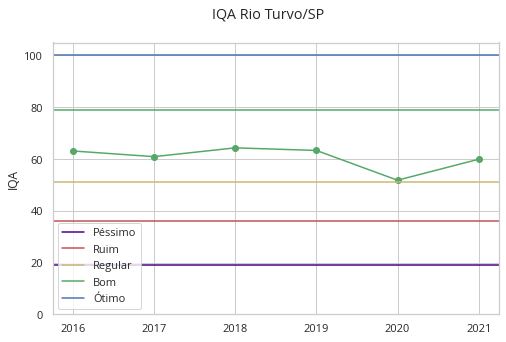

In [26]:
anos = [2016, 2017, 2018, 2019, 2020, 2021]
iqas = [iqa_16, iqa_17, iqa_18, iqa_19, iqa_20, iqa_21]

pessimo = 19
ruim = 36
regular = 51
bom = 79
otimo = 100

plt.scatter(anos, iqas, color='g')
plt.plot(anos, iqas, color='g')
plt.axhline(y=pessimo, color='#4B0082', linestyle='-', label='Péssimo')
plt.axhline(y=ruim, color='r', linestyle='-', label='Ruim')
plt.axhline(y=regular, color='y', linestyle='-', label='Regular')
plt.axhline(y=bom, color='g', linestyle='-', label='Bom')
plt.axhline(y=otimo, color='b', linestyle='-', label='Ótimo')
plt.ylim([0, 105])
plt.ylabel('IQA')
plt.suptitle('IQA Rio Turvo/SP')
plt.legend()
plt.savefig('iqa.png')
plt.show()

{'q1': 1.6979040992510166,
 'q2': 1.718244518383064,
 'q3': 1.5578699820310524,
 'q4': 1.53044917535479,
 'q5': 1.5725851608222896,
 'q6': 1.410184831428462,
 'q7': 1.377735305134685,
 'q8': 1.4162637398849458,
 'q9': 1.9913313619158097}